In [ ]:
'''

根据路路建议，看看音调之间能不能直接进行decoding。

而且我要考虑 随机组合，两个音调之间，三个音调，四个音调

编程思路:只要换一下mark就行.
把len(conds)放入脚本
chance level也改一下 = 1.0/(len(conds)/4)

'''


In [1]:

import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap
from neurora.decoding import tbyt_decoding_kfold
from neurora.rsa_plot import plot_tbyt_decoding_acc
import matplotlib.pyplot as plt


In [12]:
list_epochs_all = list()

sub_ids = [

    "pre4008_y","pre4009_y","pre4010_y","pre4011_y","pre4012_y","pre4013_y",
    "pre4014_y","pre4015_y","pre4017_y",
    "pre4021_y","pre4022_y","pre4023_y","pre4026_y","pre4027_y","pre4028_y","pre4029_y","pre4030_y",


]

# 局部 一个一个被试查看
sub_ids = [

    "pre4008_y",\

]

file_path = 'E:\实验\阅读困难\数据处理\pre4\data\\6epoch_clean_RSA\\'

for sub_id in sub_ids:
    data_path = file_path + sub_id + '_RSA-epo.fif'
    epochs_all = mne.read_epochs(fname=data_path)
    #做decoding要考虑被试内每个条件试次一样，如果被试间不一样可以用循环来解决。
    epochs_all.equalize_event_counts(method='mintime')
    list_epochs_all.append(epochs_all)

# 如果只想看某一部分的脑区,配合更改ndarray的维度
# channels_nieye = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
# epochs_nieye = epochs_all.pick(picks=channels_nieye)

'''
思路，先求ERP，然后再给ndarray，然后再计算RDM
'''

Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4008_y_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1275 matching events found
No baseline correction applied
0 projection items activated
Dropped 59 epochs: 100, 101, 103, 113, 118, 119, 131, 135, 136, 137, 139, 141, 189, 192, 193, 385, 400, 402, 403, 420, 579, 582, 585, 740, 750, 901, 905, 907, 923, 927, 1053, 1057, 1058, 1059, 1072, 1075, 1076, 1077, 1170, 1172, 1173, 1174, 1175, 1177, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1191, 1192, 1193, 1194


'\n思路，先求ERP，然后再给ndarray，然后再计算RDM\n'

In [13]:
'''
先整理单个的被试看看

data的结构要求： [n_subs, n_trials, n_chls, n_ts]
label的结构要求： [n_subs, n_trials]

'''


# 去掉三声
conds = ['101', '102', '104', '111', '112',  '114', '121', '122',  '124', '131', '132',  '134', ]
# 去掉二声
conds = ['101', '103', '104', '111', '113', '114', '121', '123', '124', '131', '133', '134', ]

conds = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', ]
num_conds = len(conds)

#初始值
subindex = 0
list_subdata = list()
list_sublabel = list()
for m in range(len(sub_ids)):
    #单个被试的数据
    epochs_forlen = list_epochs_all[m][conds[0]]
    # 每个被试的trial数量是不一样的
    # trial数不能放在第一位，第一位是condition
    num_trials = len(epochs_forlen.events[:,1])
    subdata = np.zeros([num_conds, num_trials, 62,  1001], dtype=np.float32)
    sublabel = np.zeros([0,0])

    for i in range(len(conds)):
        epochs = list_epochs_all[m][conds[i]]
        #做decoding，这里就不能是平均了吧。
        # 这里get_data()还会把所有的channel都选上，你需要pick一下,只要eeg，不要眼动数据
        data = epochs.get_data(picks='eeg')
        label_cond = epochs.events[:,2]
        #每种条件的cond
        sublabel = np.append(sublabel,label_cond)
        sublabel = np.reshape(sublabel, [1,len(sublabel[:])])
        subdata[i] = data
        # 现在是[con, trial, chan, ts]
        # [n_cons, n_subs, n_trials, n_chls, n_ts]需要这样的结构
        # 需要中间插入一个subs
    subdata = np.reshape(subdata, [num_conds, 1, num_trials, 62, 1001])
    # 在某个维度上面拉平
    # 把condition的维度乘到 trial上面？
    data_decode = np.reshape(subdata,[1, num_conds * num_trials,  62, 1001])
    list_subdata.append(data_decode)
    list_sublabel.append(sublabel)

del list_epochs_all #释放内存

'''
对label进行处理，
让每个值都除以100，如果是辅音，那么就取商，如果是音调，那么就取余数。
'''

from time import sleep

'''

每个被试trial数量不一致，所以只能循环求每个被试的accs再拼接

'''
n_subs = len(sub_ids)
n_ts = 191
accs_fuyin_allsubs = np.zeros([n_subs, n_ts])
accs_yindiao_allsubs = np.zeros([n_subs, n_ts])

In [14]:
# 音调
start_from = 0  # 从哪个index开始 因为总是中间中断,考虑从断开的地方继续.
for i in range(start_from, len(sub_ids)):
    data_decode = list_subdata[i]
    label_original = list_sublabel[i]
    label_yindiao = ((label_original-100)%10).astype(int)
    accs_yindiao = tbyt_decoding_kfold(data_decode,label_yindiao, n=4, time_win=50,time_step=5, nfolds=5, nrepeats=10, navg=10)
    accs_yindiao_allsubs[i] = accs_yindiao
    sleep(1)
    print()
    # del data_decode, label_original, label_yindiao, accs_yindiao


Calculating: [===========================================================                                         ] 59.10%

In [15]:

%matplotlib inline

plot_tbyt_decoding_acc(accs_yindiao_allsubs, start_time=-0.2, end_time=0.755, time_interval=0.005, chance=0.25,color='blue', ylim=[0,0.5], xlim=[-0.2,0.8])


In [6]:
# 辅音
start_from = 5  # 从哪个index开始 因为总是中间中断,考虑从断开的地方继续.
for i in range(start_from, len(sub_ids)):
    data_decode = list_subdata[i]
    label_original = list_sublabel[i]
    # 区别在这里
    label_fuyin = ((label_original-100)/10).astype(int)
    accs_fuyin = tbyt_decoding_kfold(data_decode,label_fuyin, n=4, time_win=50,time_step=5, nfolds=5, nrepeats=10, navg=10, time_opt='features')
    accs_fuyin_allsubs[i] = accs_fuyin
    print(i)
    sleep(10)

Calculating: [====================================================================================================] 100.00%
Decoding finished!

5
Calculating: [====================================================================================================] 100.00%
Decoding finished!

6
Calculating: [====================================================================================================] 100.00%
Decoding finished!

7
Calculating: [====================================================================================================] 100.00%
Decoding finished!

8
Calculating: [====================================================================================================] 100.00%
Decoding finished!

9
Calculating: [====================================================================================================] 100.00%
Decoding finished!

10
Calculating: [====================================================================================================] 100.00%


Significant time-windows:


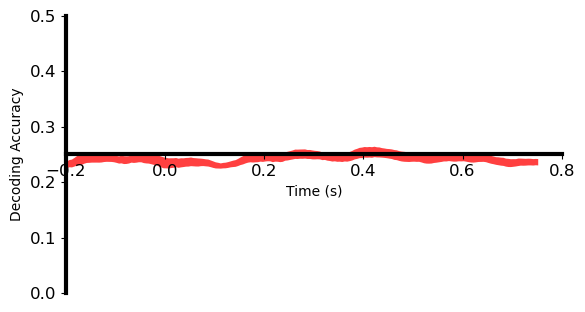

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [8]:

plot_tbyt_decoding_acc(accs_fuyin_allsubs, start_time=-0.2, end_time=0.755, time_interval=0.005, chance=0.25, color='red', ylim=[0,0.5],xlim=[-0.2,0.8], x0=-0.2, fontsize=10)

In [ ]:
%matplotlib inline
